In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

dforiginal = pd.read_csv("analysis_dataframe2.csv")

df = dforiginal.copy()
df.head()

,Unnamed: 0,Player,Tm,Pos,Age,MP,Team Performance,Team Performance (20),Season,Composite,ORtg,DRtg
0,0,Jason Terry,ATL,PG,22,1888,Average,bottom,1999-2000,0.209845,100.0,108.0
1,1,LaPhonso Ellis,ATL,PF,29,1309,Average,bottom,1999-2000,0.189767,103.0,108.0
2,2,Matt Maloney,ATL,PG,29,1403,Average,bottom,2000-2001,0.164912,100.0,107.0
3,3,DerMarr Johnson,ATL,SF,20,1313,Average,bottom,2000-2001,0.096842,88.0,106.0
4,4,Jacque Vaughn,ATL,PG,26,1856,Average,Average,2001-2002,0.199747,110.0,109.0


Here, I will be utilizing something called association mining to look for trends / relationships in my data.  

To do this, I need to have rows of binary data. for example, instead of having a column "Team Performance" with however a team did, I would have a column "Top Team" and the number being 0 or 1.  

I think I will do this with Position, Age (ranges), Season (ranges), Composite scores, ORtg, DRtg, and Team Performance (with 20 percentile)  

First let's organize our data so the algorithm will work.  

In [2]:
#calc the percentile cutoffs for Composite
top_25_cutoff_comp = dforiginal['Composite'].quantile(0.75)
bottom_25_cutoff_comp = dforiginal['Composite'].quantile(0.25)

#add binary columns for Composite
df['Top_25_Composite'] = (dforiginal['Composite'] >= top_25_cutoff_comp).astype(int)
df['Bottom_25_Composite'] = (dforiginal['Composite'] < bottom_25_cutoff_comp).astype(int)

#same thing for ORtg
top_25_cutoff_ORtg = dforiginal['ORtg'].quantile(0.75)
bottom_25_cutoff_ORtg = dforiginal['ORtg'].quantile(0.25)

df['Top_25_ORtg'] = (dforiginal['ORtg'] >= top_25_cutoff_ORtg).astype(int)
df['Bottom_25_ORtg'] = (dforiginal['ORtg'] < bottom_25_cutoff_ORtg).astype(int)

#DRtg
top_25_cutoff_DRtg = dforiginal['DRtg'].quantile(0.75)
bottom_25_cutoff_DRtg = dforiginal['DRtg'].quantile(0.25)

df['Top_25_DRtg'] = (dforiginal['DRtg'] >= top_25_cutoff_DRtg).astype(int)
df['Bottom_25_DRtg'] = (dforiginal['DRtg'] < bottom_25_cutoff_DRtg).astype(int)

#removing unecessary columns
if "Player" in df.columns.to_list():
    df = df.drop(["Unnamed: 0","Player", "Tm", "MP", "Composite", "ORtg", "DRtg"], axis=1)

df
    

,Pos,Age,Team Performance,Team Performance (20),Season,Top_25_Composite,Bottom_25_Composite,Top_25_ORtg,Bottom_25_ORtg,Top_25_DRtg,Bottom_25_DRtg
0,PG,22,Average,bottom,1999-2000,0,0,0,1,0,0
1,PF,29,Average,bottom,1999-2000,0,0,0,0,0,0
2,PG,29,Average,bottom,2000-2001,0,0,0,1,0,0
3,SF,20,Average,bottom,2000-2001,0,1,0,1,0,0
4,PG,26,Average,Average,2001-2002,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1425,PG,28,Average,Average,2020-2021,0,0,1,0,1,0
1426,SF,21,Average,Average,2021-2022,0,0,0,0,1,0
1427,SF,22,Average,Average,2021-2022,0,1,1,0,1,0
1428,SF,22,Average,Average,2022-2023,0,0,0,0,1,0


Now lets get binaries for Position and Team Performance. I will be using the top 6 and bottom six (which is around 20 percentile). By using the get_dummies function, pandas will pretty much do this for us automatically. 

In [3]:
#converting into indicator 
try:
    binary_position_columns = pd.get_dummies(df['Pos'], prefix='Pos')
    df = df.join(binary_position_columns)
except:
    print("already done!")
    pass
#this now gives us True/False, but thats fine because in Python True = 1 and False = 0 
#same thing for team team performance
try:
    binary_team_perf_columns = pd.get_dummies(df['Team Performance (20)'], prefix='Perf')
    df = df.join(binary_team_perf_columns)
except:
    print("already done!")
    pass

if "Team Performance" in df.columns.to_list():
    df= df.drop(['Pos', "Team Performance", "Team Performance (20)"], axis=1)
    
df

,Age,Season,Top_25_Composite,Bottom_25_Composite,Top_25_ORtg,Bottom_25_ORtg,Top_25_DRtg,Bottom_25_DRtg,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Perf_Average,Perf_bottom,Perf_top
0,22,1999-2000,0,0,0,1,0,0,False,False,True,False,False,False,True,False
1,29,1999-2000,0,0,0,0,0,0,False,True,False,False,False,False,True,False
2,29,2000-2001,0,0,0,1,0,0,False,False,True,False,False,False,True,False
3,20,2000-2001,0,1,0,1,0,0,False,False,False,True,False,False,True,False
4,26,2001-2002,0,0,0,0,0,0,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,28,2020-2021,0,0,1,0,1,0,False,False,True,False,False,True,False,False
1426,21,2021-2022,0,0,0,0,1,0,False,False,False,True,False,True,False,False
1427,22,2021-2022,0,1,1,0,1,0,False,False,False,True,False,True,False,False
1428,22,2022-2023,0,0,0,0,1,0,False,False,False,True,False,True,False,False


Next let's work on the ages and the time periods, 
for this, I will be categorizing the players by age. This is what it'll look like.   
0.early career - <24   
1.average ages - >= 24 , <28  
2.Late career - >=28  

and for the association mining, I will be mining 3 different times. One on a dataframe of all the players, another on a dataframe with the years from 1999-2010, and then finally one with a dataframe with the players from 2011 -2023


In [4]:
#creating these columns with binary encoding
df['Early_Career'] = (df['Age'] < 24).astype(int)
df['Average_Ages'] = ((df['Age'] >= 24) & (df['Age'] < 28)).astype(int)
df['Late_Career'] = (df['Age'] >= 28).astype(int)

if "Age" in df.columns.to_list(): #dropping age now we dont need it
    df= df.drop("Age", axis=1)
    
df

,Season,Top_25_Composite,Bottom_25_Composite,Top_25_ORtg,Bottom_25_ORtg,Top_25_DRtg,Bottom_25_DRtg,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Perf_Average,Perf_bottom,Perf_top,Early_Career,Average_Ages,Late_Career
0,1999-2000,0,0,0,1,0,0,False,False,True,False,False,False,True,False,1,0,0
1,1999-2000,0,0,0,0,0,0,False,True,False,False,False,False,True,False,0,0,1
2,2000-2001,0,0,0,1,0,0,False,False,True,False,False,False,True,False,0,0,1
3,2000-2001,0,1,0,1,0,0,False,False,False,True,False,False,True,False,1,0,0
4,2001-2002,0,0,0,0,0,0,False,False,True,False,False,True,False,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,2020-2021,0,0,1,0,1,0,False,False,True,False,False,True,False,False,0,0,1
1426,2021-2022,0,0,0,0,1,0,False,False,False,True,False,True,False,False,1,0,0
1427,2021-2022,0,1,1,0,1,0,False,False,False,True,False,True,False,False,1,0,0
1428,2022-2023,0,0,0,0,1,0,False,False,False,True,False,True,False,False,1,0,0


In [5]:
#time for creating the three different dataframes

def get_start_year(season): #getting only the first year 
    start_year = int(season.split('-')[0])
    return start_year

df['StartYear'] = df['Season'].apply(get_start_year) 
#sorting the different times (this is the same methodology as in descriptive_statistics.ipynb)
period1_df = df[(df['StartYear'] >= 1999) & (df['StartYear'] <= 2010)]  
period2_df = df[(df['StartYear'] > 2010) & (df['StartYear'] <= 2023)]

drop_columns = ["Season", "StartYear", "Bottom_25_DRtg", "Bottom_25_ORtg", "Perf_Average"] #list for dropping rows not necessary (I came back after a bunch of testing)


if "Season" in df.columns.to_list():  #dropping unnecessary columns
    period1_df= period1_df.drop(drop_columns, axis=1)
    period2_df = period2_df.drop(drop_columns, axis=1)
    df = df.drop(drop_columns, axis=1)

df



,Top_25_Composite,Bottom_25_Composite,Top_25_ORtg,Top_25_DRtg,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Perf_bottom,Perf_top,Early_Career,Average_Ages,Late_Career
0,0,0,0,0,False,False,True,False,False,True,False,1,0,0
1,0,0,0,0,False,True,False,False,False,True,False,0,0,1
2,0,0,0,0,False,False,True,False,False,True,False,0,0,1
3,0,1,0,0,False,False,False,True,False,True,False,1,0,0
4,0,0,0,0,False,False,True,False,False,False,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,0,0,1,1,False,False,True,False,False,False,False,0,0,1
1426,0,0,0,1,False,False,False,True,False,False,False,1,0,0
1427,0,1,1,1,False,False,False,True,False,False,False,1,0,0
1428,0,0,0,1,False,False,False,True,False,False,False,1,0,0


Now its time for the fun part, the mining. Here are three major terms to optimize this process. Here's a simple definition
1. Support - The frequency with which certain combinations of data points show up in the dataset.  
2. Confidence - The probability that one data point occurs when another data point is already present in an observation.  
3. Lift - An indication of whether the presence of one data point is likely to make another data point occur more than just by random chance.  

In [6]:

from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df, min_support=0.04, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

rules_with_lift = rules[(rules['lift'] >= 1.0) &
                        (rules['consequents'].apply(lambda cons: 'Perf_bottom' in cons or 'Perf_top' in cons))]


rules_with_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']]



c:\Users\ieyua\OneDrive\Desktop\GitHub\sports-analysis-project\.conda\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
18,"(Early_Career, Top_25_DRtg)",(Perf_bottom),0.041259,0.460938,2.354074


As we can see, these are some lame associations. These are the associations we got:  
- if a player is in his early career and is in the top 25 percentile of bench players for defensive efficiency, he is 46 percent likely to be on a bottom team. 

While this is pretty interesting, theres only one conclusion!

So, instead of trying to do association mining with all these columns, I'm going to segment these columns and look for associations. Instead, I will be taking a dataframe on only top and bottom teams, and then include a couple columns at a time. 

In [7]:
df_top_teams = df[df['Perf_top'] == 1]
df_bottom_teams = df[df['Perf_bottom'] == 1]


df_top_teams

,Top_25_Composite,Bottom_25_Composite,Top_25_ORtg,Top_25_DRtg,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Perf_bottom,Perf_top,Early_Career,Average_Ages,Late_Career
20,1,0,1,0,False,False,False,False,True,False,True,0,0,1
21,0,1,1,0,False,False,False,True,False,False,True,0,0,1
30,0,0,0,0,False,False,True,False,False,False,True,1,0,0
31,0,1,0,0,False,False,False,False,True,False,True,0,1,0
64,0,0,1,0,False,True,False,False,False,False,True,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,0,0,1,0,False,False,True,False,False,False,True,1,0,0
1320,0,0,1,0,False,False,True,False,False,False,True,0,1,0
1321,0,1,0,0,False,False,False,True,False,False,True,1,0,0
1322,1,0,0,0,True,False,False,False,False,False,True,0,0,1


In [8]:
# You've selected the columns for age and position
age_columns = [col for col in df.columns if 'Age' in col]
position_columns = [col for col in df.columns if "Pos" in col]

#including relevant columns
relevant_columns = position_columns + age_columns + ['Perf_top'] + ['Top_25_Composite']	+ ['Bottom_25_Composite'] + ["Top_25_ORtg"] + ["Top_25_DRtg"]

#create a new df with only the relevant columns
df_top_age = df_top_teams[relevant_columns]
frequent_itemsets_top_age = apriori(df_top_age, min_support=0.08, use_colnames=True)
rules_top_age = association_rules(frequent_itemsets_top_age, metric="confidence", min_threshold=0.4)

# filter rules by lift and ensure perf_top is in the consequents
rules_top_age_with_lift = rules_top_age[(rules_top_age['lift'] >= 1.01) &
                                        (rules_top_age['consequents'].apply(lambda cons: 'Perf_top' in cons))]

#display the rules
rules_top_age_with_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

c:\Users\ieyua\OneDrive\Desktop\GitHub\sports-analysis-project\.conda\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
19,(Pos_PF),"(Top_25_ORtg, Perf_top)",0.085714,0.400000,1.046729
22,(Pos_PG),"(Perf_top, Average_Ages)",0.092857,0.426230,1.170042
25,(Pos_PG),"(Top_25_ORtg, Perf_top)",0.092857,0.426230,1.115367
28,(Pos_SF),"(Bottom_25_Composite, Perf_top)",0.085714,0.500000,1.647059
35,(Average_Ages),"(Top_25_ORtg, Perf_top)",0.146429,0.401961,1.051860
38,(Top_25_Composite),"(Top_25_ORtg, Perf_top)",0.089286,0.555556,1.453790
42,(Top_25_DRtg),"(Top_25_ORtg, Perf_top)",0.096429,0.627907,1.643121


### lets do some visualizations! 

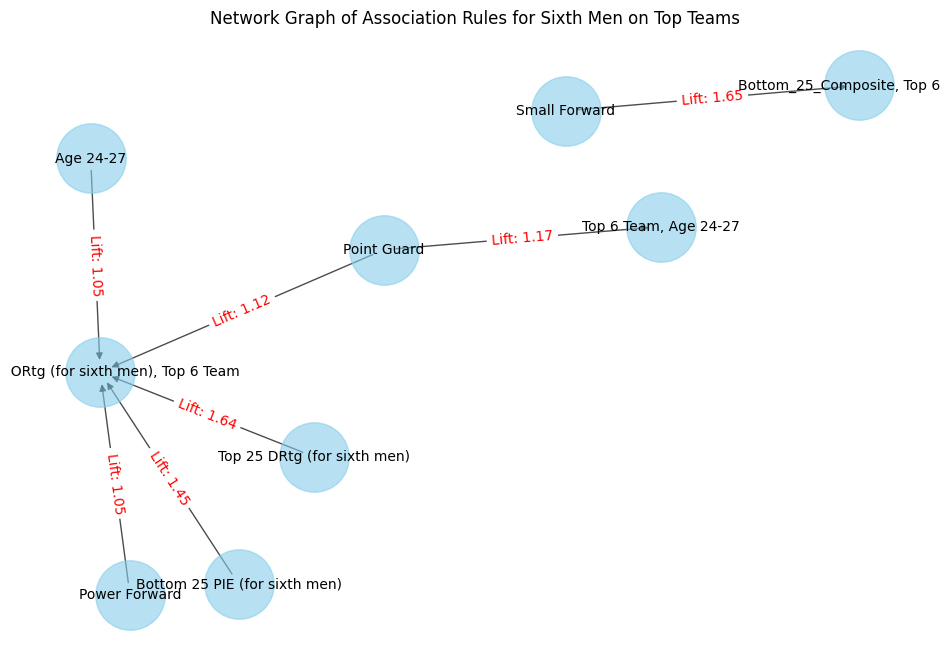

C:\Users\ieyua\AppData\Local\Temp\ipykernel_19100\2352485520.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: apply_label_mapping(x, label_mapping))
C:\Users\ieyua\AppData\Local\Temp\ipykernel_19100\2352485520.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: apply_label_mapping(x, label_mapping))


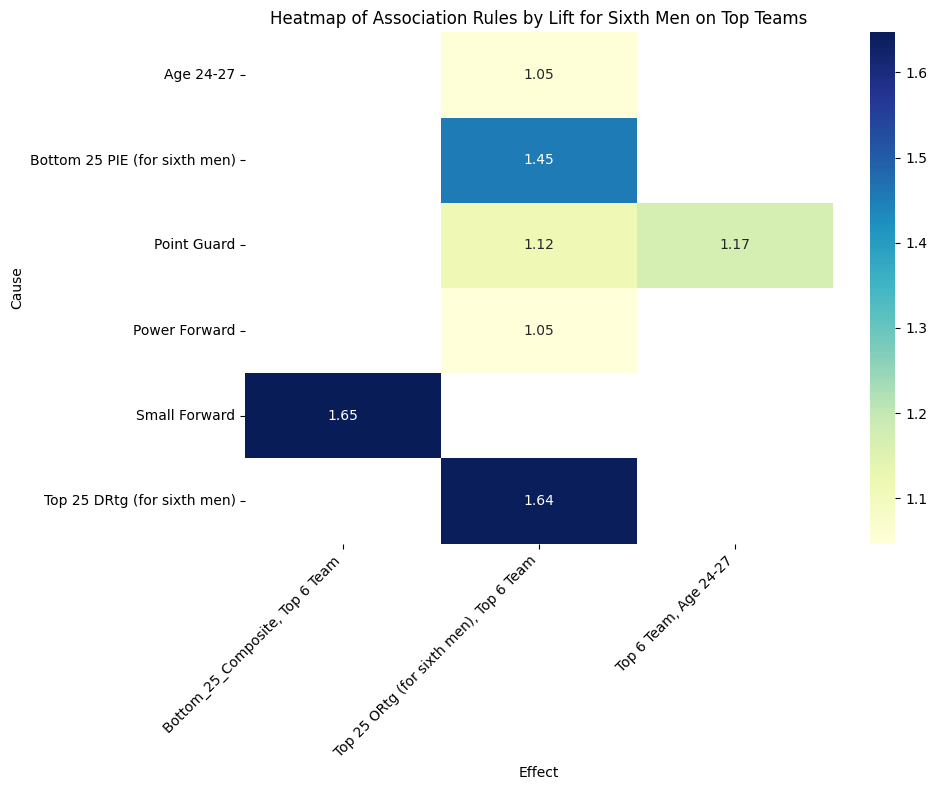

In [28]:
label_mapping = {
    'Perf_top': 'Top 6 Team',
    'perf_bottom': 'Bottom 6 Team',
    'Pos_PF' : "Power Forward", 
    "Pos_PG" : "Point Guard", 
    "Average_Ages" : "Age 24-27", 
    "Top_25_ORtg" : "Top 25 ORtg (for sixth men)", 
    "Top_25_DRtg": "Top 25 DRtg (for sixth men)",
    "Pos_SF" : "Small Forward", 
    "Early_Career" : "Under 23",
    "Late_Career" : "Over 28",
    "Pos_C" : "Center", 
    "Top_25_Composite": "Top 25 PIE (for sixth men)", 
    "Top_25_Composite" : "Bottom 25 PIE (for sixth men)"
    
}

def apply_label_mapping(itemset, mapping): #making graphs more readable
    return ', '.join([mapping.get(item, item) for item in list(itemset)])


def draw_network_graph(rules, topic="hi"): #function for creating graph
    #create a new graph
    G = nx.DiGraph()
    
    #add nodes and edges from the rules
    for _, rule in rules.iterrows():
        antecedents = apply_label_mapping(rule['antecedents'], label_mapping)
        consequents = apply_label_mapping(rule['consequents'], label_mapping)
        
        #add an edge for the rule
        G.add_edge(antecedents, consequents, weight=rule['lift'])
    
    pos = nx.spring_layout(G, k=0.5, iterations=20)
    plt.figure(figsize=(12, 8))
    
    #draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='skyblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7)
    
    #labels
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    #edge labels
    edge_labels = {(u, v): f"Lift: {d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    if topic is not None:
        plt.title(f'Network Graph of Association Rules for Sixth Men on {topic}')
    else:
        plt.title(f'Network Graph of Association Rules')
    plt.axis('off')
    plt.savefig(f"visualization/network_graph_{topic}.png", bbox_inches='tight') 
    plt.show()
    
def create_rules_heatmap(rules_df, metric='lift', topic="hi"):
    #apply label mapping to each antecedent and consequent
    rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: apply_label_mapping(x, label_mapping))
    rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: apply_label_mapping(x, label_mapping))
    
    #creating a pivot table for the heatmap
    pivot_table = rules_df.pivot_table(index='antecedents_str', columns='consequents_str', values=metric, aggfunc='mean')
    
    #plotting the heatmap
    plt.figure(figsize=(10, 8))  #adjust the figure size as needed
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".2f")  #using color map, annotating with metric values
    plt.title(f'Heatmap of Association Rules by {metric.capitalize()} for Sixth Men on {topic}')
    plt.xlabel('Effect')
    plt.ylabel('Cause')
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    plt.tight_layout()  #adjust layout to make room for the rotated x-axis labels
    
    plt.savefig(f"visualization/heat_map_{topic}.png", bbox_inches='tight')  
    plt.show()
    
draw_network_graph(rules_top_age_with_lift, "Top Teams")

create_rules_heatmap(rules_top_age_with_lift, 'lift', "Top Teams")


Here's a quick analysis of each 
- Power forwards (PFs) on top 6 teams tend to have an individual offensive efficiency rating within the top 25%. The support of 0.085714 indicates this association is present in approximately 8.57% of the transactions. With a confidence of 40%, when a PF is observed, there's a 40% chance they are on a top team and have a high offensive rating. The lift of 1.046729 suggests a slightly above expected occurrence of this combination, indicating a mild positive association.
- Point guards (PGs) who are aged 24-27 are more likely to be on top 6 teams. This rule has a support of 0.092857, a confidence of 42.6230%, and a lift of 1.170042, indicating that the association is relatively common and stronger than random chance, suggesting that teams benefit from having point guards in this age range.
- Similar to power forwards, point guards on top 6 teams frequently have an individual offensive efficiency in the top 25%. The support and confidence are the same as the previous rule involving PGs, with a lift of 1.115367, implying that having point guards with high offensive efficiency is beneficial for a team's performance.
- Small forwards (SFs) on top 6 teams are associated with being in the bottom 25% of composite scores (a pie score reflecting overall impact). This has a support of 0.085714, a high confidence of 50%, and a lift of 1.647059, suggesting that top teams might have successful SFs whose individual composite scores are not high, possibly indicating a role-focused contribution rather than statistical dominance.
- Players aged 24-27 are associated with being on top 6 teams and having a top 25% offensive efficiency. With a support of 0.146429 and confidence of 40.1961%, this suggests a trend where players in this age range contribute significantly to their team's offensive efficiency. The lift of 1.051860 implies a positive association.
- Players with a top 25% composite score are likely to be on top 6 teams and have a top 25% offensive efficiency, indicating a strong correlation between overall impact and offensive performance for top teams. This association has a confidence of 55.5556% and a lift of 1.453790, reinforcing the importance of high-performing players.
- Players with a top 25% individual defensive efficiency are highly likely to be on top 6 teams and also have a top 25% offensive efficiency, suggesting that top teams often have players who excel both offensively and defensively. This rule shows the highest confidence at 62.7907% and a significant lift of 1.643121, highlighting the value of balanced individual performance in contributing to team success.


In [ ]:
#same thing for other df
relevant_columns_bottom = position_columns + age_columns + ['Perf_bottom'] + ['Top_25_Composite'] + ['Bottom_25_Composite'] + ["Top_25_ORtg"] + ["Top_25_DRtg"]
df_bottom_age = df_bottom_teams[relevant_columns_bottom]
frequent_itemsets_bottom_age = apriori(df_bottom_age, min_support=0.08, use_colnames=True)
rules_bottom_age = association_rules(frequent_itemsets_bottom_age, metric="confidence", min_threshold=0.4)
rules_bottom_age_with_lift = rules_bottom_age[(rules_bottom_age['lift'] >= 1.01) &
                                              (rules_bottom_age['consequents'].apply(lambda cons: 'Perf_bottom' in cons))]

rules_bottom_age_with_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

In [ ]:
draw_network_graph(rules_bottom_age_with_lift)


conclusions for this 
- Power forwards (PFs) on bottom teams are as likely to have top 25% composite scores. This suggests that despite high individual performance or impact scores, PFs can still be on teams that do not perform well overall.
- Point guards (PGs) on bottom teams frequently have top 25% defensive efficiency ratings. This indicates that point guards with strong defensive capabilities can still find themselves on lower-ranking teams.
- Shooting guards (SGs) on bottom teams are highly likely to have top 25% defensive efficiency ratings, suggesting that SGs with good defense are not uncommon in lower-performing teams.
- Players with top 25% composite scores on bottom teams tend to be within the average age range (24-27). This might indicate that even players in their prime, with high individual performance, are part of teams that don't rank well.
- Similarly, players in the average age range on bottom teams often have top 25% composite scores, reinforcing the idea that individual performance does not always correlate with team success.
- Players within the average age range on bottom teams frequently have top 25% defensive efficiency ratings, suggesting that defensive skill in this age group does not necessarily lead to overall team success.
- Players with top 25% offensive efficiency on bottom teams are likely to also have top 25% composite scores, indicating that high offensive skill and overall impact are present even among lower-ranking teams.
- Players with bottom 25% composite scores on bottom teams tend to have top 25% defensive efficiency ratings, which could suggest that players with lower overall impact may still excel defensively.
- Players with top 25% offensive efficiency on bottom teams often have top 25% defensive efficiency as well, highlighting that players can be highly efficient on both ends of the floor even if their team is not performing well.
- Shooting guards with top 25% defensive efficiency on bottom teams are likely to be in the average age range, suggesting that SGs in their prime with strong defensive skills can be on lower-ranking teams.
- Shooting guards in the average age range on bottom teams have a very high likelihood of having top 25% defensive efficiency, further emphasizing the presence of defensive talent in lower-ranking teams.
- Players in the average age range with top 25% defensive efficiency are likely to be shooting guards on bottom teams, indicating a specific trend where SGs in their prime with high defensive efficiency are not uncommon in teams with lower rankings.




### what did I learn? 

well this was definetly very interesting. I have significantly gained knowledge in my understanding of data analysis, gaining insight into complex patterns and relationships within these datasets. For example, one key concept I gained knowledge about is overfitting, a phenomenon where a mdoel learns the training data too closely and fails to generalize to new data. I also learned about differnet metrics like confidence, lift, and support. This project has not only expanded my vocab but also provided epxerience in testing and comparing different models, sharpening my analyttical skills and enhancing my ability to extract meaningful insights from complex data. 


